# Для исследования разностных схем будем использовать задачу Самарского-Соболя-Зельдовича

$$
\begin{cases}
 \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}u^{\alpha}\frac{\partial u}{\partial x} \\
 u(x, 0) = 0 \\
 u(0, t) = ct^{1/\alpha} \\
 \lim_{x \rightarrow +\inf}u(x,t) = 0
 \end{cases}
$$

## Неявная разностная схема с нелинейностью на нижнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
from celluloid import Camera
from numba import njit
import utils

### Реализация

In [40]:
@njit
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [41]:
@njit
def make_diagonals(u, n, tau, h, M, alpha=2.5, kappa=0.2):
    # init variables
    a = np.zeros(M - 1)
    b = np.zeros(M)
    c = np.zeros(M - 1)
    d = np.zeros(M)
    sigma = kappa * tau / h ** 2
    y = u[n, :]
    # first row
    b[0] = 1
    d[0] = - u[n + 1, 0]
    # rows m = 2,...,M - 1
    for m in range(1, M - 1):
        a[m - 1] = k_12(y[m - 1], y[m], alpha) * sigma
        c[m] = k_12(y[m], y[m + 1], alpha) * sigma
        b[m] = 1 + a[m - 1] + c[m]
        d[m] = - y[m]
    # last row
    m = M - 1
    b[m] = 1
    d[m] = - y[m]
    return a, b, c, d

In [42]:
@njit
def thomas_solver(a, b, c, d):
    # init arrays
    M = len(b)
    u_sol = np.zeros(M)
    P = np.zeros(M)
    Q = np.zeros(M)
    # Forward first coefs
    P[0] = c[0] / b[0]
    Q[0] = - d[0] / b[0]
    # Forward coefs n = 1 ... M - 1
    for m in range(1, M - 1):
        P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
        Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
    #Forward last
    m = M - 1
    Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]

    return u_sol

### Применение

In [3]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [4]:
# Число узлов
N = 6000
M = 100

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02020202, tau= 0.00066678
sigma =  0.8169


In [5]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [6]:
u = np.zeros((N, M), dtype=np.double)
u[:, 0] = const * t ** (1 / alpha)

In [47]:
for n in tqdm(range(N - 1)):
    a_e, b_e, c_e, d_e = make_diagonals(u, n, tau, h, M, alpha=alpha, kappa=kappa)
    u_sol = thomas_solver(a_e, b_e, c_e, d_e)
    u[n + 1, :] = u_sol

  0%|          | 0/5999 [00:00<?, ?it/s]

#### Визуализация

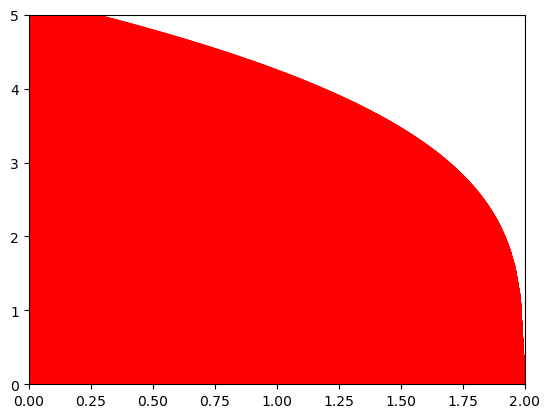

In [58]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 5))

for i in range(0, N, 10):
    ax.plot(x, u[i, :], color="red")
    ax.fill_between(x, u[i, :], color='red', alpha=0.3)
    camera.snap()

In [59]:
animation = camera.animate()
animation.save('spitz.gif', writer = 'imagemagick', fps=tau * 10 * 1e3)

MovieWriter imagemagick unavailable; using Pillow instead.


In [60]:
from IPython.display import Image
Image(url='spitz.gif')

## Неявная разностная схема с нелинейностью на нижнем слое для моих начальных условий

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

### Реализация

In [58]:
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [59]:
def make_diagonals(u, n, tau, h, M, alpha=2.5, kappa=0.2):
    # init variables
    a = np.zeros(M - 1)
    b = np.zeros(M)
    c = np.zeros(M - 1)
    d = np.zeros(M)
    sigma = kappa * tau / h ** 2
    y = u[n, :]
    # first row
    c[0] = k_12(y[0], y[1], alpha) * sigma
    b[0] = 1 + c[0]
    d[0] = - y[0]
    # rows m = 2,...,M - 1
    for m in range(1, M - 1):
        a[m - 1] = k_12(y[m - 1], y[m], alpha) * sigma
        c[m] = k_12(y[m], y[m + 1], alpha) * sigma
        b[m] = 1 + a[m - 1] + c[m]
        d[m] = - y[m]
    # last row
    m = M - 1
    b[m] = 1
    d[m] = - y[m]
    return a, b, c, d

In [60]:
def thomas_solver(a, b, c, d):
    # init arrays
    M = len(b)
    u_sol = np.zeros(M)
    P = np.zeros(M)
    Q = np.zeros(M)
    # Forward first coefs
    P[0] = c[0] / b[0]
    Q[0] = - d[0] / b[0]
    # Forward coefs n = 1 ... M - 1
    for m in range(1, M - 1):
        P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
        Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
    #Forward last
    m = M - 1
    Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]

    return u_sol

### Применение

In [61]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [62]:
# Число узлов
N = 6000
M = 100

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02020202, tau= 0.00066678
sigma =  0.8169


In [63]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [64]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

In [65]:
u = np.zeros((N + 1, M), dtype=np.double)
u[0, :] = u_init(x, 2)

In [70]:
np.seterr(all='warn')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [71]:
for n in tqdm(range(N - 1)):
    a_e, b_e, c_e, d_e = make_diagonals(u, n, tau, h, M, alpha=alpha, kappa=kappa)
    u_sol = thomas_solver(a_e, b_e, c_e, d_e)
    u[n + 1, :] = u_sol

  0%|          | 0/5999 [00:00<?, ?it/s]

C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\445448729.py:2: RuntimeWarning: underflow encountered in double_scalars
  return (y_m ** alpha + y_m_1 ** alpha) / 2
C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\598935392.py:12: RuntimeWarning: underflow encountered in double_scalars
  P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\598935392.py:13: RuntimeWarning: underflow encountered in double_scalars
  Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\598935392.py:21: RuntimeWarning: underflow encountered in double_scalars
  u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]
C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\3514771672.py:16: RuntimeWarning: underflow encountered in double_scalars
  c[m] = k_12(y[m], y[m + 1], alpha) * sigma
C:\Users\aleks\AppData\Local\Temp\ipykernel_13120\3514771672.py:15: RuntimeWarning: underflow encountered in double_scalars
  a[m - 1

#### Визуализация

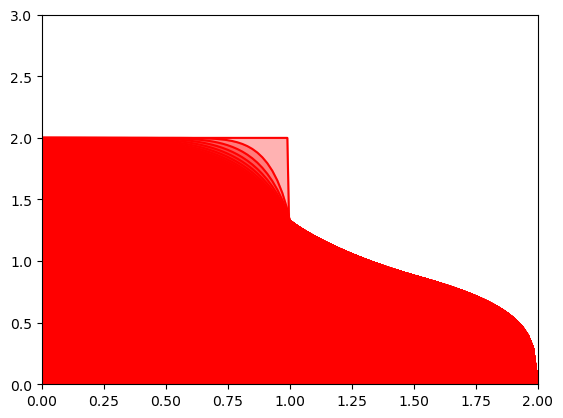

In [72]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 3))

for i in range(0, N, 10):
    ax.plot(x, u[i, :], color="red")
    ax.fill_between(x, u[i, :], color='red', alpha=0.3)
    camera.snap()

In [73]:
animation = camera.animate()
animation.save('spitzer_one.gif', writer = 'imagemagick', fps=tau * 10 * 1e3)

MovieWriter imagemagick unavailable; using Pillow instead.


In [60]:
from IPython.display import Image
Image(url='spitz.gif')

## Неявная разностная схема с нелинейностью на верхнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на верхнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^{n + 1}_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^{n+1}_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

### Реализация

In [9]:
@njit
def k_12(y_m, y_m_1, alpha, kappa=None):
    kappa = 1 if kappa is None else kappa
    return kappa * (y_m ** alpha + y_m_1 ** alpha) / 2

In [10]:
@njit
def thomas_solver(a, b, c, d):
    # init arrays
    M = len(b)
    u_sol = np.zeros(M)
    P = np.zeros(M)
    Q = np.zeros(M)
    # Forward first coefs
    P[0] = c[0] / b[0]
    Q[0] = - d[0] / b[0]
    # Forward coefs n = 1 ... M - 1
    for m in range(1, M - 1):
        P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
        Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
    #Forward last
    m = M - 1
    Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]

    return u_sol

In [11]:
@njit
def make_diagonals(y_s, tau, h, y_n, alpha=2.5, kappa=0.2):
    # init variables
    M = len(y_s)
    a = np.zeros(M - 1)
    b = np.zeros(M)
    c = np.zeros(M - 1)
    d = np.zeros(M)
    sigma = tau / h ** 2
    dkappa = lambda x: kappa * 0.5 * alpha * x ** (alpha - 1)
    # first row
    b[0] = 1
    d[0] = 0
    # rows m = 2,...,M - 1
    for m in range(1, M - 1):
        a[m - 1] = k_12(y_s[m - 1], y_s[m], alpha, kappa) -  dkappa(y_s[m - 1]) * (y_s[m] - y_s[m - 1])
        c[m] = k_12(y_s[m + 1], y_s[m], alpha, kappa) +  dkappa(y_s[m + 1]) * (y_s[m + 1] - y_s[m])
        b[m] = 1 / sigma + k_12(y_s[m + 1], y_s[m], alpha, kappa) + k_12(y_s[m - 1], y_s[m], alpha, kappa) - dkappa(y_s[m]) * (y_s[m + 1] - y_s[m]) + dkappa(y_s[m]) * (y_s[m] - y_s[m - 1])
        d[m] = (y_s[m] - y_n[m]) / sigma - k_12(y_s[m + 1], y_s[m], alpha, kappa) * (y_s[m + 1] - y_s[m]) + k_12(y_s[m - 1], y_s[m], alpha, kappa) * (y_s[m] - y_s[m - 1])
    # last row
    m = M - 1
    b[m] = 1
    d[m] = 0
    return a, b, c, d

In [12]:
@njit
def newton_solver(y, y_left, tau, h, alpha=2.5, kappa=0.2, iter=10):
    y_n, y_s = y, y
    y_s[0] = y_left
    for i in range(iter):
        a, b, c, d = make_diagonals(y_s, tau, h, y_n, alpha=alpha, kappa=kappa)
        dy = thomas_solver(a, b, c, d)
        y_s = y_s + dy
    return y_s

### Применение

In [13]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [14]:
# Число узлов
N = 6000
M = 100

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02020202, tau= 0.00066678
sigma =  0.8169


In [15]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [16]:
u = np.zeros((N, M), dtype=np.double)
u[:, 0] = const * t ** (1 / alpha)

In [17]:
for n in tqdm(range(N - 1)):
    u_sol = newton_solver(u[n, :], u[n + 1, 0], tau, h, alpha=2.5, kappa=0.2, iter=10)
    u[n + 1, 1:] = u_sol[1:]

  0%|          | 0/5999 [00:00<?, ?it/s]

#### Визуализация

In [18]:
def zeldovich_solution(x, t, alpha, kappa, const):
    u_sol = np.zeros_like(x)
    v = kappa * const ** alpha / alpha
    for i in range(len(x)):
        if x[i] - v * t <= 0:
            u_sol[i] = (alpha * v / kappa * (v * t - x[i])) ** (1 / alpha)
        else:
            u_sol[i] = 0
    return u_sol

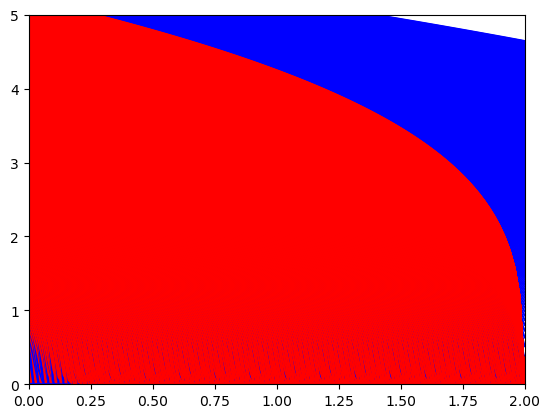

In [19]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 5))

for i in range(0, N, 10):
    ax.plot(x, u[i, :], color="red")
    ax.fill_between(x, u[i, :], color='red', alpha=0.3)
    zeld_sol = zeldovich_solution(x, t[i], alpha, kappa, const)
    ax.plot(x, zeld_sol, color="blue")
    camera.snap()

In [20]:
animation = camera.animate()
animation.save('zeldovich_true.gif', writer = 'imagemagick', fps=tau * 10 * 1e3)

MovieWriter imagemagick unavailable; using Pillow instead.


## Неявная разностная схема с нелинейностью на верхнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^{n + 1}_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^{n+1}_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

In [26]:
def k_12(y_m, y_m_1, alpha, kappa=None):
    kappa = 1 if kappa is None else kappa
    return kappa * (y_m ** alpha + y_m_1 ** alpha) / 2

In [32]:
from numpy.linalg import inv


def thomas_block_solver(A, B, C, D):
    M = len(D)
    u_sol = np.zeros_like(D)
    P = np.zeros_like(B)
    Q = np.zeros_like(D)
    # Forward first coefs
    P[0] = inv(B[0]) @ C[0]
    Q[0] = - inv(B[0]) @ D[0]
    # Forward coefs
    for m in range(1, M - 1):
        inv_denom = inv(B[m] - A[m - 1] @ P[m - 1])
        P[m] = inv_denom @ C[m]
        Q[m] = inv_denom @ (A[m - 1] @ Q[m - 1] - D[m])
    #Forward last
    m = M - 1
    Q[m] = inv(B[m] - A[m - 1] @ P[m - 1]) @ (A[m - 1] @ Q[m - 1] - D[m])

    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] @ u_sol[m] + Q[m - 1]

    return u_sol

In [31]:
def make_block(u, m, tau, h, u_prev, alpha=(2.5, 1.5), kappa=(0.2, 0.3)):
    alpha = np.array(alpha)
    kappa = np.array(kappa)
    sigma = tau / h ** 2
    dkappa = lambda x: 0.5 * kappa * alpha * x ** (alpha - 1)
    if m == 0:
        C = np.diagflat(k_12(u[m], u[m + 1], alpha, kappa) + dkappa(u[m + 1]) * (u[m + 1] - u[m]))
        B = np.diagflat(1 / sigma + k_12(u[m], u[m + 1], alpha, kappa) + dkappa(u[m]) * (u[m + 1] - u[m]))
        D = (u[m] - u_prev[m]) / sigma - k_12(u[m + 1], u[m], alpha, kappa) * (u[m + 1] - u[m])
        return C, B, D
    A = np.diagflat(k_12(u[m - 1], u[m], alpha, kappa) + dkappa(u[m - 1]) * (u[m] - u[m - 1]))
    C = np.diagflat(k_12(u[m], u[m + 1], alpha, kappa) + dkappa(u[m + 1]) * (u[m + 1] - u[m]))
    B = np.diagflat(1 / sigma + k_12(u[m], u[m + 1], alpha, kappa) + k_12(u[m - 1], u[m], alpha, kappa) + 2 * dkappa(u[m]) * (u[m + 1] - u[m - 1]))
    D = (u[m] - u_prev[m]) / sigma - k_12(u[m + 1], u[m], alpha, kappa) * (u[m + 1] - u[m]) + k_12(u[m], u[m - 1], alpha, kappa) * (u[m] - u[m - 1])
    return A, B, C, D

In [33]:
def make_block_diagonals(u1, u2, tau, h, u1_init, u2_init, alpha=(2.5, 1.5), kappa=(0.2, 0.3)):
    M = len(u1_init)
    A = np.zeros((M - 1, 2, 2))
    B = np.zeros((M, 2, 2))
    C = np.zeros((M - 1, 2, 2))
    D = np.zeros((M, 2))
    u_prev = np.vstack([u1, u2]).reshape(-1, 2)
    u = np.vstack([u1_init, u2_init]).reshape(-1, 2)
    # first row
    B[0], C[0], D[0] = make_block(u, 0, tau, h, u_prev, alpha=alpha, kappa=kappa)
    # rows m = 1, ..., M - 2
    for m in range(1, M - 1):
        A[m], B[m], C[m], D[m] = make_block(u, m, tau, h, u_prev, alpha=(2.5, 1.5), kappa=(0.2, 0.3))
    # last row
    B[M - 1] = np.eye(2)
    return A, B, C, D

In [47]:
def newton_solver(u1, u2, tau, h, u1_init, u2_init, alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=10):
    for i in range(iter):
        print(i)
        A, B, C, D = make_block_diagonals(u1, u2, tau, h, u1_init, u2_init, alpha=alpha, kappa=kappa)
        du = thomas_block_solver(A, B, C, D)
        u1_init = u1_init + du[:, 0]
        u2_init = u2_init + du[:, 1]
        print(du)
    return u1_init, u2_init

### Применение

In [35]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [36]:
# Число узлов
N = 6000
M = 100

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02020202, tau= 0.00066678
sigma =  0.8169


In [5]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [37]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

In [38]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [41]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [48]:
for n in tqdm(range(N - 1)):
    u1_sol, u2_sol = newton_solver(u1[n, :], u2[n, :], tau, h, u1[n, :], u2[n, :], alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=10)
    u1[n + 1, :], u2[n + 1, :] = u1_sol, u2_sol

  0%|          | 0/5999 [00:00<?, ?it/s]

0
[[ 2.76155820e-08  3.68967496e-08]
 [ 1.79204693e-08  2.14348536e-08]
 [ 4.55360513e-08  5.83316033e-08]
 [ 9.77869900e-08  1.37305486e-07]
 [ 2.02941448e-07  3.15323811e-07]
 [ 4.17888804e-07  7.20798970e-07]
 [ 8.58917241e-07  1.64621790e-06]
 [ 1.76462656e-06  3.75912570e-06]
 [ 3.62501254e-06  8.58365502e-06]
 [ 7.44655839e-06  1.95999496e-05]
 [ 1.52967501e-05  4.47545436e-05]
 [ 3.14226021e-05  1.02192544e-04]
 [ 6.45483254e-05  2.33346490e-04]
 [ 1.32595193e-04  5.32823449e-04]
 [ 2.72377088e-04  1.21664923e-03]
 [ 5.59517100e-04  2.77809723e-03]
 [ 1.14936020e-03  6.34350808e-03]
 [ 2.36101608e-03  1.44847683e-02]
 [ 4.84999995e-03  3.30745245e-02]
 [ 9.96287140e-03  7.55223795e-02]
 [ 2.04657335e-02  1.72447825e-01]
 [ 4.20407161e-02  3.93767417e-01]
 [ 8.63600520e-02  8.99128642e-01]
 [ 1.77400845e-01  2.05307062e+00]
 [ 3.64416871e-01  4.68798209e+00]
 [ 1.31066927e+00  4.65715117e+00]
 [-1.81698312e+00 -1.61405422e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 

FloatingPointError: invalid value encountered in power

In [40]:
u1[:5, :]

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na